<a href="https://colab.research.google.com/gist/GunjanGrunge/3eac49e0a28ed64fd3ce6c8498cc0d36/tabular-playground-series-oct-2021-with-nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
 ! pip install -q kaggle

In [4]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gunjangrunge","key":"12c22c0a1b53b426a15f24413ac11977"}'}

In [5]:
!mkdir -p ~/.kaggle

In [7]:
!cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [8]:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [9]:
!kaggle competitions download tabular-playground-series-oct-2021

 99% 434M/438M [00:05<00:00, 78.9MB/s]
100% 438M/438M [00:05<00:00, 80.1MB/s]
 99% 871M/877M [00:16<00:00, 67.5MB/s]
100% 877M/877M [00:16<00:00, 55.3MB/s]
  0% 0.00/1.12M [00:00<?, ?B/s]
100% 1.12M/1.12M [00:00<00:00, 37.2MB/s]


In [10]:
def reduce_mem_usage(df, verbose=True):
    """
    function to reduce memory

    """
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                else:
                    df[col] = df[col].astype(np.float32)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [13]:
#pip install datatable

     |████████████████████████████████| 96.9 MB 59 kB/s 


In [44]:
import random
random.seed(123)

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
import datatable as dt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [15]:
"""
train = dt.fread(r'../input/tabular-playground-series-oct-2021/train.csv').to_pandas()
test = dt.fread(r'../input/tabular-playground-series-oct-2021/test.csv').to_pandas()
sub = dt.fread(r'../input/tabular-playground-series-oct-2021/sample_submission.csv').to_pandas()
""" 

"\ntrain = dt.fread(r'../input/tabular-playground-series-oct-2021/train.csv').to_pandas()\ntest = dt.fread(r'../input/tabular-playground-series-oct-2021/test.csv').to_pandas()\nsub = dt.fread(r'../input/tabular-playground-series-oct-2021/sample_submission.csv').to_pandas()\n"

In [16]:
train = dt.fread(r'/content/train.csv.zip').to_pandas()
test = dt.fread(r'/content/test.csv.zip').to_pandas()
sub = dt.fread(r'/content/sample_submission.csv.zip').to_pandas()

In [19]:
train_1 = reduce_mem_usage(train)
test_1= reduce_mem_usage(test)

Mem. usage decreased to 505.45 Mb (73.1% reduction)
Mem. usage decreased to 252.25 Mb (73.1% reduction)


### Using Train and test with reduced memory 

In [23]:
train_1.head()

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,...,f246,f247,f248,f249,f250,f251,f252,f253,f254,f255,f256,f257,f258,f259,f260,f261,f262,f263,f264,f265,f266,f267,f268,f269,f270,f271,f272,f273,f274,f275,f276,f277,f278,f279,f280,f281,f282,f283,f284,target
0,0,0.205933,0.410889,0.176758,0.223633,0.423584,0.476074,0.413574,0.611816,0.534668,0.147339,0.026184,0.106628,0.200928,0.713379,0.155762,0.557129,0.341797,0.285645,0.230347,0.203979,0.509766,0.707031,True,0.007793,0.247803,0.263672,0.259521,0.231689,0.138428,0.197876,0.054382,0.194214,0.281494,0.034821,0.025330,0.114441,0.139160,0.246216,0.251465,...,True,False,False,False,False,False,False,True,False,True,True,False,False,False,True,False,False,True,True,False,False,False,True,True,False,True,False,True,True,False,False,True,False,False,False,False,False,False,False,True
1,1,0.181030,0.473145,0.011734,0.213623,0.619629,0.441650,0.230347,0.686035,0.281982,0.238525,0.493408,0.107300,0.231812,0.457031,0.395264,0.617188,0.459473,0.209229,0.201050,0.199341,0.366699,0.585938,True,0.285400,0.400391,0.162476,0.249390,0.141113,0.133667,0.247925,0.139282,0.216431,0.109680,0.033020,0.017456,0.189331,0.168823,0.184204,0.202759,...,True,False,False,True,False,True,False,True,True,False,False,False,True,False,False,False,False,True,True,False,True,True,False,False,False,True,False,False,True,True,False,True,False,False,False,False,False,False,False,True
2,2,0.182617,0.307373,0.325928,0.207153,0.605469,0.309814,0.493408,0.750977,0.536133,0.286865,0.139526,0.107239,0.247803,0.631836,0.347412,0.642090,0.257812,0.162598,0.327393,0.193604,0.495361,0.636719,False,0.007133,0.309814,0.221069,0.284912,0.230835,0.138306,0.199707,0.060394,0.146729,0.208130,0.035980,0.022629,0.113525,0.274902,0.182739,0.151489,...,True,True,False,False,True,False,False,False,False,False,False,False,True,True,False,True,False,False,False,False,False,False,False,False,True,True,False,False,True,False,False,False,False,True,True,False,False,False,False,True
3,3,0.180298,0.494629,0.008369,0.223633,0.760742,0.439209,0.432129,0.776367,0.483887,0.260986,0.147095,0.105408,0.287842,0.455811,0.247925,0.616699,0.335938,0.336914,0.239136,0.176147,0.538086,0.706543,True,0.008827,0.353760,0.219971,0.266846,0.145630,0.138550,0.234985,0.059814,0.140869,0.205078,0.319336,0.009972,0.112305,0.288818,0.332520,0.140869,...,True,True,False,True,True,False,True,True,False,True,False,False,False,False,False,False,False,False,True,False,True,True,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True
4,4,0.177124,0.495605,0.014259,0.548828,0.625488,0.562500,0.117188,0.561035,0.077087,0.158325,0.260254,0.102539,0.265381,0.503906,0.269775,0.545898,0.319580,0.278564,0.214966,0.200195,0.534668,0.728516,False,0.004841,0.323486,0.166260,0.285400,0.208618,0.200439,0.198120,0.414795,0.251953,0.193359,0.034485,0.016464,0.197266,0.207397,0.255859,0.139893,...,False,False,False,True,True,True,False,True,False,True,False,False,True,True,False,True,False,False,False,True,False,False,False,False,True,True,False,False,True,False,False,True,True,False,True,False,False,True,False,True


In [28]:
train_1.isnull().sum()

id        0
f0        0
f1        0
f2        0
f3        0
         ..
f281      0
f282      0
f283      0
f284      0
target    0
Length: 287, dtype: int64

In [29]:
pd.set_option('display.max_columns', 125)
train_1.describe()

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,...,f180,f181,f182,f183,f184,f185,f186,f187,f188,f189,f190,f191,f192,f193,f194,f195,f196,f197,f198,f199,f200,f201,f202,f203,f204,f205,f206,f207,f208,f209,f210,f211,f212,f213,f214,f215,f216,f217,f218,f219,f220,f221,f222,f223,f224,f225,f226,f227,f228,f229,f230,f231,f232,f233,f234,f235,f236,f237,f238,f239,f240,f241
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,499999.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.063171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.058868,NaN,0.030426,NaN,NaN,NaN,NaN,NaN,NaN,0.051208,0.056366,0.058685,NaN,NaN,NaN,NaN,NaN,0.030685,NaN,NaN,NaN,NaN,NaN,NaN,0.056824,0.034241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.042053,NaN,NaN,NaN,NaN,NaN,NaN,0.045197,0.055023,0.034973,0.042175,NaN,0.022476,0.034363,NaN,NaN,NaN,NaN,NaN,NaN,0.020630,NaN,NaN,NaN,NaN
std,288675.278933,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.118774,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111633,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.116394,0.000000,0.097717,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.114929,0.114197,0.131714,0.000000,0.000000,0.000000,0.000000,0.000000,0.075134,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.147583,0.077332,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.087280,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0889

In [21]:
#converting the Target column to numrcal values i.r 0 or 1. 
train_1.target = train_1.target.astype('int16')
train_1.info()
print()
test_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Columns: 287 entries, id to target
dtypes: bool(45), float16(240), int16(1), int32(1)
memory usage: 506.4 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Columns: 286 entries, id to f284
dtypes: bool(45), float16(240), int32(1)
memory usage: 252.2 MB


In [22]:
from sklearn.model_selection import train_test_split

X = train_1.drop("target", axis=1)
y = train_1['target']

In [23]:
print(train_1.target.dtype)
print(train_1.target[:10])



int16
0    1
1    1
2    1
3    1
4    1
5    0
6    1
7    1
8    1
9    0
Name: target, dtype: int16


In [24]:
X = train_1 
Y = X.target
X.drop('target', axis = 1, inplace = True)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2,
                                                                         random_state = 42)
X_test = test_1

In [26]:
from sklearn.impute import SimpleImputer

my_imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean', verbose = False)
my_imputer.fit(X_train)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=False)

In [27]:
X_train_imputed = my_imputer.transform(X_train)


In [29]:
X_valid_imputed = my_imputer.transform(X_val)


In [30]:
X_test_imputed = my_imputer.transform(X_test)

In [33]:
standard_scaler = StandardScaler()
standard_scaler.fit(X_train_imputed)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [34]:
X_train_scaled = standard_scaler.transform(X_train_imputed)


In [35]:
X_valid_scaled = standard_scaler.transform(X_valid_imputed)
X_test_scaled = standard_scaler.transform(X_test_imputed)

In [ ]:
#Converting the numpy array to dataframe as standard scaler transforms the dataframe to Np Array

In [38]:
X_train_final = pd.DataFrame(X_train_scaled, index = X_train.index,
                            columns = X_train.columns)

In [39]:
X_valid_final = pd.DataFrame(X_valid_scaled, index = X_val.index, 
                            columns = X_val.columns)
X_test_final = pd.DataFrame(X_test_scaled, index = X_test.index, 
                           columns = X_test.columns)

In [40]:
X_train_final.describe().T

,count,mean,std,min,25%,50%,75%,max
id,800000.0,-7.476686e-17,1.000001,-1.732277,-0.865583,-0.000253,0.866408,1.731879
f0,800000.0,-9.925363e-16,1.000001,-3.235789,-0.612875,-0.184784,0.286802,14.734289
f1,800000.0,-4.008405e-17,1.000001,-4.324157,-0.699357,-0.063432,0.651983,4.833668
f2,800000.0,5.013441e-17,1.000001,-1.067368,-0.924086,-0.279577,0.401194,6.979456
f3,800000.0,1.408101e-16,1.000001,-4.396328,-0.669413,-0.205482,0.447888,10.975261
...,...,...,...,...,...,...,...,...
f280,800000.0,-5.607012e-15,1.000001,-0.401828,-0.401828,-0.401828,-0.401828,2.488629
f281,800000.0,2.630224e-15,1.000001,-0.498885,-0.498885,-0.498885,-0.498885,2.004472
f282,800000.0,5.157738e-15,1.000001,-0.430170,-0.430170,-0.430170,-0.430170,2.324661
f283,800000.0,-7.700436e-16,1.000001,-0.474316,-0.474316,-0.474316,-0.474316,2.108297


In [42]:
nn = keras.Sequential([
    layers.BatchNormalization(input_shape = [X_train_final.shape[1]]),
    layers.Dense(units = 200, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate = 0.2),
    layers.Dense(units = 100, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate = 0.2),
    layers.Dense(units = 50, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate = 0.2),
    layers.Dense(units = 10, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate = 0.2),
    layers.Dense(units = 1, activation = 'sigmoid')
])

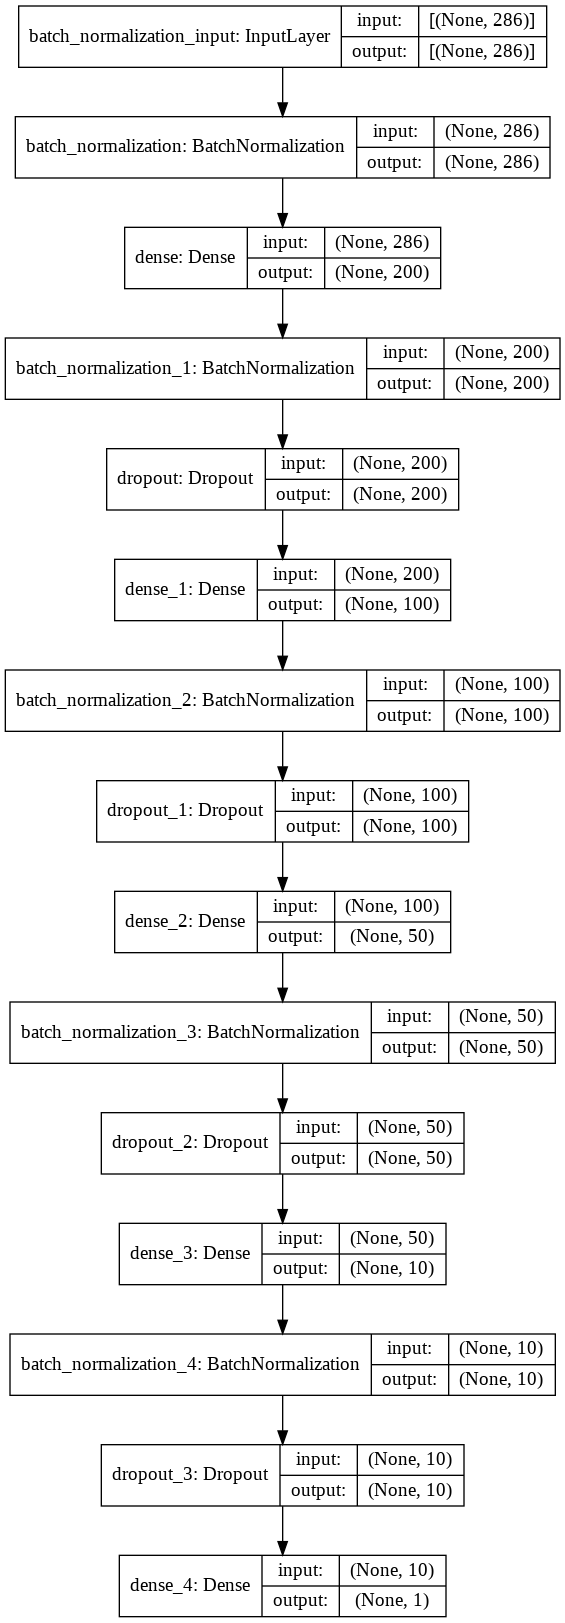

In [45]:


tf.keras.utils.plot_model(nn, show_shapes=True)


In [47]:
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 286)               1144      
_________________________________________________________________
dense (Dense)                (None, 200)               57400     
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0

In [48]:
auc = keras.metrics.AUC(name = 'auc')
nn.compile(optimizer = keras.optimizers.Adam(learning_rate = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 0.01, decay_steps = 9000, decay_rate = 0.9)),
             loss = 'binary_crossentropy',
             metrics = [auc])

In [53]:
early_stopping = keras.callbacks.EarlyStopping(patience = 10,
                                min_delta = 0.001,
                                restore_best_weights = False)

In [56]:
history = nn.fit(X_train_final, Y_train,
                   validation_data = (X_valid_final,Y_val),
                   batch_size = 500,
                   epochs = 50, callbacks = [early_stopping])

Epoch 1/50
1600/1600 [==============================] - 22s 14ms/step - loss: 0.4355 - auc: 0.8745 - val_loss: 0.4998 - val_auc: 0.8375
Epoch 2/50
1600/1600 [==============================] - 21s 13ms/step - loss: 0.4349 - auc: 0.8748 - val_loss: 0.4964 - val_auc: 0.8375
Epoch 3/50
1600/1600 [==============================] - 21s 13ms/step - loss: 0.4351 - auc: 0.8748 - val_loss: 0.5001 - val_auc: 0.8373
Epoch 4/50
1600/1600 [==============================] - 22s 14ms/step - loss: 0.4344 - auc: 0.8751 - val_loss: 0.4997 - val_auc: 0.8371
Epoch 5/50
1600/1600 [==============================] - 21s 13ms/step - loss: 0.4343 - auc: 0.8752 - val_loss: 0.4989 - val_auc: 0.8373
Epoch 6/50
1600/1600 [==============================] - 21s 13ms/step - loss: 0.4340 - auc: 0.8754 - val_loss: 0.4973 - val_auc: 0.8370
Epoch 7/50
1600/1600 [==============================] - 22s 14ms/step - loss: 0.4335 - auc: 0.8757 - val_loss: 0.5029 - val_auc: 0.8372
Epoch 8/50
1600/1600 [==========================

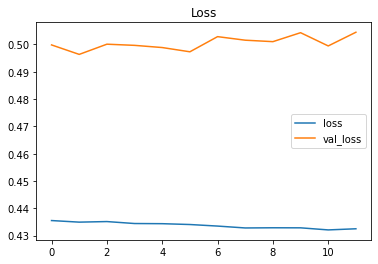

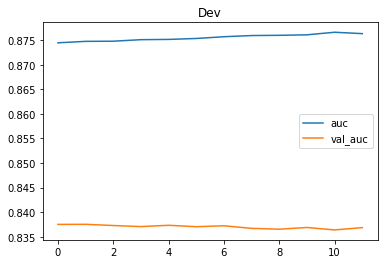

In [57]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot(title = 'Loss')
history_df.loc[:,['auc','val_auc']].plot(title = 'Dev')

In [63]:
X_test_final.shape

(500000, 286)

In [64]:
preds = nn.predict(X_test_final)

In [65]:
preds = preds.reshape(len(X_test_final),)

In [67]:
output = pd.DataFrame({'id' : X_test_final.index,
                      'target' : preds})
output.to_csv('submission.csv', index = False)